## Evaluating different classifiers to predict passenger survival in Titanic Dataset

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from scipy import stats
from IPython.display import display

In [2]:
# Read data into Dataframe
df_dev = pd.read_csv("titanic-dev.csv")
df_hold = pd.read_csv("titanic-heldout.csv")

Data Preview
    survived  pclass  sex     age     fare
0       1.0     3.0  1.0  0.1667  20.5750
1       0.0     3.0  0.0  0.3333  14.4000
2       1.0     3.0  0.0  0.4167   8.5167
3       1.0     2.0  0.0  0.6667  14.5000
4       0.0     3.0  0.0  0.7500  13.7750

Data Profile
          survived      pclass         sex         age        fare
count  945.000000  945.000000  945.000000  945.000000  945.000000
mean     0.410582    2.204233    0.375661   29.666931   36.833077
std      0.492200    0.838420    0.484550   14.410045   54.877383
min      0.000000    1.000000    0.000000    0.166700    0.000000
25%      0.000000    1.000000    0.000000   21.000000    8.050000
50%      0.000000    2.000000    0.000000   28.000000   15.850000
75%      1.000000    3.000000    1.000000   39.000000   36.750000
max      1.000000    3.000000    1.000000   80.000000  512.329200

Missing Value Check
 survived    0
pclass      0
sex         0
age         0
fare        0
dtype: int64

Class Balance
     

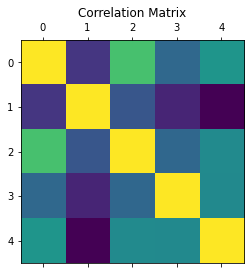

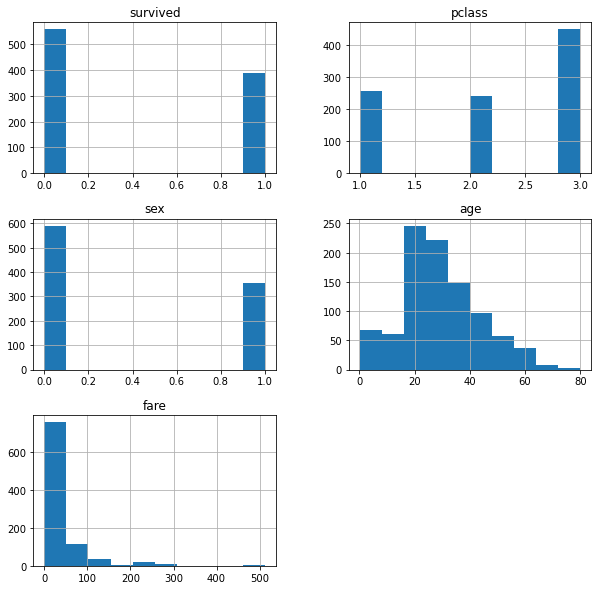

In [3]:
# Preview data
print("Data Preview\n", df_dev.head())
print("\nData Profile\n", df_dev.describe())
print("\nMissing Value Check\n",df_dev.isna().sum())
print("\nClass Balance\n",df_dev.groupby('survived').count())
print("\nCorrelation Matrix\n",df_dev.corr())
plt.matshow(df_dev.corr());
plt.title("Correlation Matrix")
df_dev.hist(figsize=(10,10));


In [4]:
# Divide data into X and y
X_dev = df_dev.drop('survived',axis = 1)
y_dev = df_dev['survived']
X_hold = df_hold.drop('survived',axis = 1)
y_hold = df_hold['survived']

In [5]:
# Helper function used to update the resutls for the classifications
def update_results(clf,X_train,X_test,y_train,y_test,cross_val):
    if cross_val>0:
        cv = StratifiedKFold(n_splits = cross_val,random_state =2,shuffle=True)
        cv_score = cross_val_score(clf, X_train, y_train, cv = cv)
        std_err = stats.sem(cv_score)
        test_acc = str(round(cv_score.mean(),3)) + " +/- " + str(round(std_err,3))
    else:
        y_pred_test = clf.fit(X_train, y_train).predict(X_test)
        test_acc = accuracy_score(y_test, y_pred_test)
    return test_acc

# To test 4 different classifiers
def test_classifiers(X_train,y_train,X_test,y_test,cross_val):
    classifier_name = []
    test_acc_set = []
    
    # Naive Bayes
    gnb = GaussianNB()
    classifier_name.append("Naive Bayes")
    test_acc_set.append(update_results(gnb,X_train,X_test,y_train,y_test,cross_val))
    
    # Decision Tree
    dt = DecisionTreeClassifier(max_depth = 3,random_state =2)
    classifier_name.append("Decision Tree")
    test_acc_set.append(update_results(dt,X_train,X_test,y_train,y_test,cross_val))
    
    # K-neighbors
    kn = KNeighborsClassifier()
    classifier_name.append("K-Neighbors")
    test_acc_set.append(update_results(kn,X_train,X_test,y_train,y_test,cross_val))
    
    # Random Forest
    rf = RandomForestClassifier(max_depth = 2,random_state =2)
    classifier_name.append("Random Forest")
    test_acc_set.append(update_results(rf,X_train,X_test,y_train,y_test,cross_val))
    
    return classifier_name,test_acc_set
    

In [6]:
# Function to evaluate classifiers on different test-train splits
def experiment_1():
    # Method A: Train on the first 473 items and test on the remaining 472. 
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.499,shuffle = False)
    classifier_name,classifier_acc = test_classifiers(X_train,y_train,X_test,y_test,cross_val = 0)
    
    output_dict = {
        'Classifier': classifier_name,
        'Method A': classifier_acc
    }
    # Method B: Train on a random subset of 473 items and test on the remaining 472.
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.499,shuffle = True,random_state =2)
    _,classifier_acc = test_classifiers(X_train,y_train,X_test,y_test,cross_val=0)
    output_dict['Method B'] = classifier_acc
    
    # Method C: Two-fold cross validation (report average test fold accuracy + standard error) 
    _,classifier_acc = test_classifiers(X_dev,y_dev,None,None,cross_val=2)
    output_dict['Method C'] = classifier_acc
    
    # Method D: Ten-fold cross validation (report average test fold accuracy + standard error) 
    _,classifier_acc = test_classifiers(X_dev,y_dev,None,None,cross_val=10)
    output_dict['Method D'] = classifier_acc
    
    # Method E: Develop your own strategy for train/test split(s) to evaluate the classifiers.
    X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.3, shuffle = True,random_state =2)
    _,classifier_acc = test_classifiers(X_train,y_train,X_test,y_test,cross_val=0)
    output_dict['Method E'] = classifier_acc
    
    # Table output
    output_df = pd.DataFrame(output_dict)
    display(output_df.style.hide_index())
    output_dict.clear()
    del output_df

In [7]:
# Function to generate accuracy of the baseline classifier
def baseline_classifier(X_dev,y_dev,X_hold):
    dummy_clf = DummyClassifier(strategy="stratified")
    y_dummy_pred = dummy_clf.fit(X_dev, y_dev).predict(X_hold)
    dummy_acc = dummy_clf.score(X_hold, y_dummy_pred)
    return dummy_acc

# Function to evaluate classifiers by training on entire training data
def experiment_2():
    
    # Testing on holdout set
    classifier_name,classifier_acc = test_classifiers(X_dev,y_dev,X_hold,y_hold,cross_val = 0)
    output_dict = {
        'Classifier': classifier_name,
        'Accuracy': classifier_acc,
    }
    
    # Testing accuracy based on gender split
    X_hold_male = X_hold[X_hold['sex']==0]
    y_hold_male = y_hold[df_hold['sex']==0]
    X_hold_female = X_hold[X_hold['sex']==1]
    y_hold_female = y_hold[df_hold['sex']==1]
    
    _,classifier_acc = test_classifiers(X_dev,y_dev,X_hold_male,y_hold_male,cross_val = 0)
    output_dict['Accuracy: Male'] = classifier_acc
    
    _,classifier_acc = test_classifiers(X_dev,y_dev,X_hold_female,y_hold_female,cross_val = 0)
    output_dict['Accuracy: Female'] = classifier_acc
    
    # Adding baseline readings for comparision
    output_dict["Classifier"].append('Baseline')
    output_dict["Accuracy"].append(baseline_classifier(X_dev,y_dev,X_hold))
    output_dict['Accuracy: Male'].append(baseline_classifier(X_dev,y_dev,X_hold_male))
    output_dict['Accuracy: Female'].append(baseline_classifier(X_dev,y_dev,X_hold_female))
    
    # Table output
    output_df = pd.DataFrame(output_dict)
    display(output_df.style.hide_index())
    output_dict.clear()
    del output_df
    

In [8]:
print("Evaluating Exp1 ")
experiment_1()

Evaluating Exp1 


Classifier,Method A,Method B,Method C,Method D,Method E
Naive Bayes,0.684322,0.766949,0.765 +/- 0.023,0.774 +/- 0.015,0.774648
Decision Tree,0.828390,0.783898,0.768 +/- 0.022,0.811 +/- 0.009,0.774648
K-Neighbors,0.627119,0.629237,0.651 +/- 0.023,0.655 +/- 0.013,0.661972
Random Forest,0.815678,0.781780,0.766 +/- 0.014,0.77 +/- 0.009,0.774648


In [9]:
print("Evaluating Exp2 ")
experiment_2()

Evaluating Exp2 


Classifier,Accuracy,Accuracy: Male,Accuracy: Female
Naive Bayes,0.730000,0.731343,0.727273
Decision Tree,0.760000,0.776119,0.727273
K-Neighbors,0.700000,0.686567,0.727273
Random Forest,0.740000,0.776119,0.666667
Baseline,0.540000,0.522388,0.545455


In [10]:
# My passenger using Decision Tree

#Using DT as it performed best
dt = DecisionTreeClassifier(max_depth = 3,random_state = 2)
fare_set = []
pclass_set = []
#Loop to iterate towards the 3 classes
for pclass in range(1,4):
    pclass_set.append(pclass)
    fare = 0
    y_pred_test = 0
    #Loop to figure stop when preditction is true
    while y_pred_test!=1:
        my_pass = {
            'pclass': [pclass],
            'sex' : [0],
            'age': [24],
            'fare': [fare]
        }
        y_pred_test = dt.fit(X_dev, y_dev).predict(pd.DataFrame(my_pass))
        fare+=1
        #If true add the fare to the set
        if y_pred_test == 1:
            fare_set.append(fare)
            break
        # If fare greater than upper bound, predict that passenger does not survive
        elif fare>1000:
            fare_set.append("Does not survive")
            break
print("Pclass",pclass_set)
print("FareSet",fare_set)

Pclass [1, 2, 3]
FareSet ['Does not survive', 'Does not survive', 'Does not survive']


In [11]:
# Looking for subgroups
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev,test_size=0.499,shuffle = True,random_state=2)
_,classifier_acc = test_classifiers(X_train,y_train,X_test[X_test['sex']==1],y_test[X_test['sex']==1],cross_val=0)
classifier_acc

[0.7528735632183908,
 0.7931034482758621,
 0.5632183908045977,
 0.7586206896551724]